[STATUS] features shape: (600, 532)
[STATUS] labels shape: (600,)
[STATUS] training started...
[STATUS] splitted train and test data...
Train data  : (540, 532)
Test data   : (60, 532)
Train labels: (540,)
Test labels : (60,)
LR: 0.700000 (0.053544)
LDA: 0.368519 (0.056444)
KNN: 0.505556 (0.043073)
CART: 0.653704 (0.064177)
RF: 0.790741 (0.046885)
NB: 0.637037 (0.059835)
SVM: 0.685185 (0.061419)


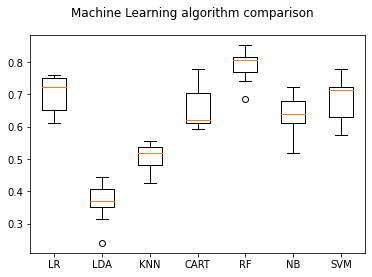

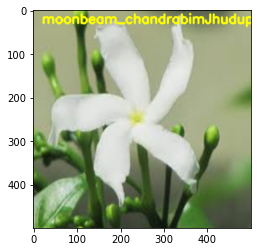

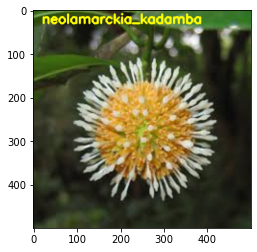

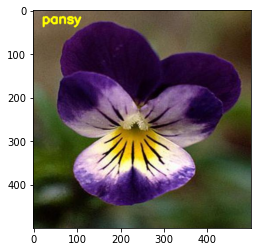

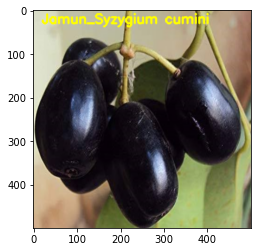

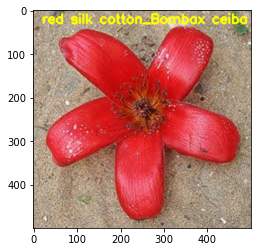

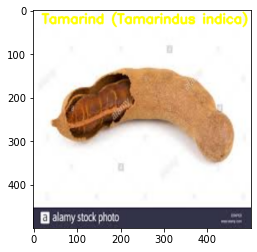

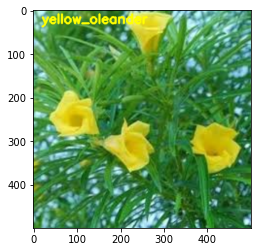

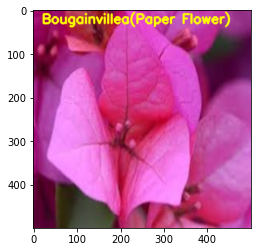

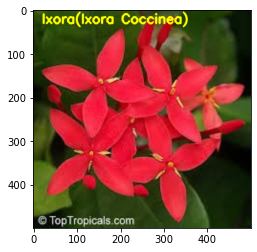

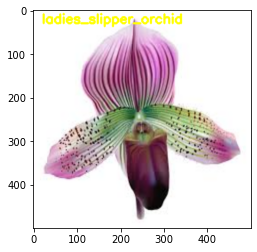

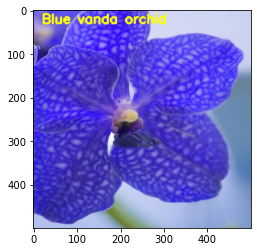

In [7]:

import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib
import import_ipynb
from glo import*
warnings.filterwarnings('ignore')


num_trees = 100
test_size = 0.10
seed      = 9
train_path = "dataset/train"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"


train_labels = os.listdir(train_path)



train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)


models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))


results = []
names   = []


h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()


print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")


(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))


for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()




import matplotlib.pyplot as plt


clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)


clf.fit(trainDataGlobal, trainLabelsGlobal)


for file in glob.glob(test_path + "/*.jpg"):
    
    image = cv2.imread(file)

   
    image = cv2.resize(image, fixed_size)

   
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    
    scaler = MinMaxScaler(feature_range=(0, 1))
    global_feature= np.reshape(global_feature, (2, -1))
    rescaled_feature = scaler.fit_transform(global_feature)

    
    prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

   
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

   
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()